In [2]:
import sklearn
import time
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import cv2
from color import colors

from numpy.linalg import inv

from scipy.spatial.distance import euclidean,cityblock,squareform
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster,cophenet

from fastdtw import fastdtw

from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering
import scipy.spatial.distance as ssd

# Load the data

### Opening the database

In [3]:
data_file = "laurier/laurier.sqlite"
#data_file = "grl/grl.sqlite"
data_base = sqlite3.connect(data_file)
cursor = data_base.cursor()
#data_base.commit()


### Get the trajectories

##### Get the number of trajectories

In [4]:
db_request1 = "SELECT max(trajectory_id), min(trajectory_id) FROM positions"
max_min = cursor.execute(db_request1).fetchall()
nb_trajectory = max_min[0][0]- max_min[0][1] +1


In [5]:
print(nb_trajectory)

1792


##### Get (x,y) coordinates for trajectories

In [6]:
trajectories = np.array([
    cursor.execute(
        "SELECT p.x_coordinate,p.y_coordinate \
        FROM positions as p \
        WHERE trajectory_id ="+str(i)+" ORDER BY p.frame_number ASC"
    ).fetchall() for i in range(nb_trajectory)
])

##### Get (x,y) coordinates for trajectory's velocities

In [7]:
velocities = np.array([
    cursor.execute(
        "SELECT v.x_coordinate,v.y_coordinate \
        FROM velocities as v \
        WHERE trajectory_id ="+str(i)+" ORDER BY v.frame_number ASC"
    ).fetchall() for i in range(nb_trajectory)
])

In [8]:
print(trajectories[0])
print(len(trajectories[0]))
print("")
print(velocities[0])
print(len(velocities[0]))

[(151.464, 46.1908), (151.585, 45.9867), (151.711, 45.7869), (151.831, 45.586), (151.952, 45.3858), (152.072, 45.1853), (152.195, 44.9845), (152.318, 44.7837), (152.443, 44.5829), (152.569, 44.3814), (152.692, 44.1805), (152.817, 43.9795), (152.948, 43.777), (153.082, 43.574), (153.217, 43.3708)]
15

[(0.120834, -0.203487), (0.12472, -0.201144), (0.121344, -0.201434), (0.121161, -0.200901), (0.1205, -0.200605), (0.122398, -0.200806), (0.123724, -0.200841), (0.125119, -0.20082), (0.125398, -0.201504), (0.127424, -0.201423), (0.129344, -0.201953), (0.133807, -0.202906), (0.135722, -0.203702), (0.132263, -0.202122)]
14


## Display data

##### Refactor from [[(x,y),(x1,y1)]] to [[x,x1],[y,y1]] and plot

In [14]:
def refactor_and_plot(trajectories):
    trajectories_disp = np.array([[[e[0] for e in trajectory], [e[1] for e in trajectory]] for trajectory in trajectories ])
    for e in trajectories_disp:

        plt.plot(e[1],e[0])
    plt.show()

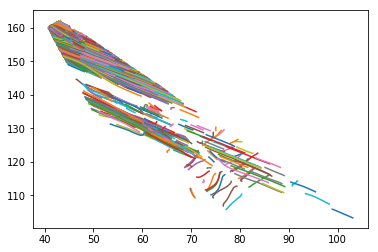

In [23]:
refactor_and_plot(trajectories)

#### Observation

Pas le bon système de coordonnées.
On prend l'homographie fournie avec la base de donnée dans "laurier-homography.txt"
On l'inverse et on l'applique sur les points pour passer des mètres aux pixels

## Transformation

##### Charger l'homographie

In [9]:
H = np.loadtxt("laurier/laurier-homography.txt")
#H = np.loadtxt("grl/homography.txt")
h = inv(H)

In [10]:
def meters_to_pixels(meter_points,h):
    pixel_points = []
    for meter_point in meter_points:
        new_points = []
        for point in meter_point:
            new_point = np.array([point[0],point[1],1])
            new_point = np.matmul(h,new_point)
            new_point = [new_point[0]/new_point[2],new_point[1]/new_point[2]]
            new_points.append(new_point)
        pixel_points.append(new_points)
    return pixel_points

##### Appliquer l'homographie sur tous les points

In [11]:
pixel_trajectories = meters_to_pixels(trajectories,h)

In [12]:
pixel_velocities =  meters_to_pixels(velocities,h)

[[540.98503834572853, 668.00719874054403], [551.63440105777613, 675.40970610546719]]


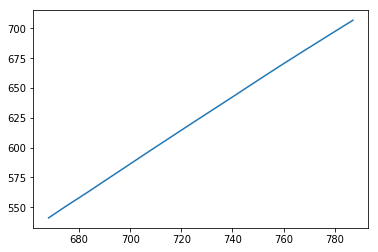

In [19]:

print(pixel_trajectories[0][0:2])
refactor_and_plot([pixel_trajectories[0]])


## Histogram of length repartition for trajectories

We want to find a threshold in trajectory length to eliminate the noise

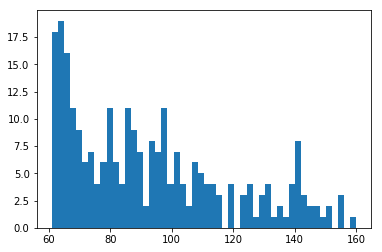

In [88]:
lengths = [len(t) for t in pixel_trajectories]
plt.hist(lengths,bins=50)
plt.show()

In [18]:
pixel_trajectories = [t for t in pixel_trajectories if len(t)> 40]


In [89]:
print(len(pixel_trajectories))

260


In [90]:
mean = np.mean(lengths)
std = np.std(lengths)
print(mean,std)

92.4923076923 26.3531478645


In [11]:
img_shape = (1280, 720, 3)

# Data preprocessing

## Discretization spatial tile transformation

In [14]:
def discretize(square_side_size,trajectory):
    Discretized_trajectory = []
    for point in trajectory:
        i = int(point[1]/square_side_size)
        j = int(point[0]/square_side_size)
        square = [i,j]
        if  len(Discretized_trajectory) == 0 or Discretized_trajectory[-1] != square:
            Discretized_trajectory.append(square)
    return Discretized_trajectory

Discretized Trajectory

In [19]:
square_side_size = 50
discretized_pixel_trajectories = [discretize(square_side_size,trajectory) for trajectory in pixel_trajectories]
#discretized_pixel_trajectories = discretized_pixel_trajectories.reshape(-1,1)


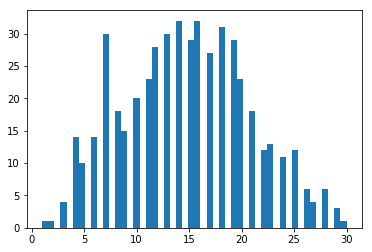

In [20]:
lengths = [len(t) for t in discretized_pixel_trajectories]
plt.hist(lengths,bins=50)
plt.show()

## Data cleaning

# Clustering

### Compute the distance matrix

In [70]:
def distance_matrix(trajectories):
    l =len(trajectories)
    D = np.zeros((l,l))
    for i in range(l):
        for j in range(i,l):
            #D[i,j] = my_affinity_wrapper(trajectories[i],trajectories[j])
            #D[i,j],p = fastdtw(trajectories[i],trajectories[j], dist=euclidean)
            D[i,j],p = fastdtw(trajectories[i],trajectories[j], dist=cityblock)
            D[j,i] = D[i,j]
    return D    

In [92]:
times=[]
start = time.time()
D = distance_matrix(discretized_pixel_trajectories[:])
end = time.time()-start
times.append(end)
print(end)


83.80447316169739


In [93]:
np.savetxt("laurier/distance_thresh_60_dis_50.txt",D)

## Clustering algorithms

### Distance matrix based

### Modèles

## Hierarchical clustering

In [94]:
#D = np.loadtxt("Distances/cityblock_50.txt")
Z = linkage(squareform(D), 'ward')


#### Cophenet distance:  
The closer the value is to 1, 
the better the clustering preserves the original distances, which in our case is pretty close

In [95]:
c, coph_dists = cophenet(Z, squareform(D))
print(c)

0.694296642071


#### Show the evolution of the merged distances for last merges

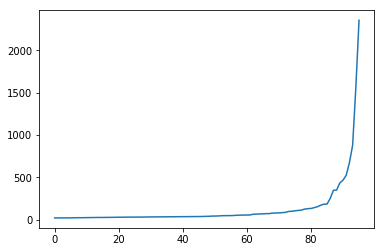

In [75]:
plt.plot(Z[400:,2])
plt.show()

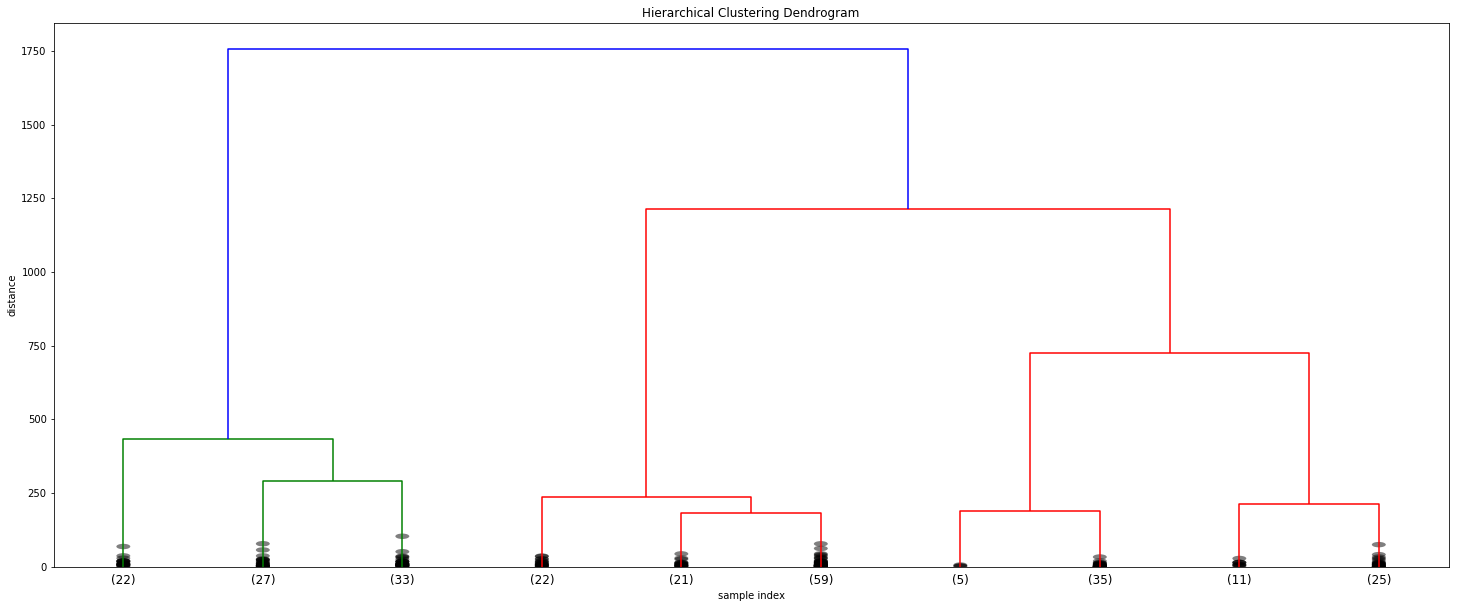

In [96]:

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,
    show_contracted=True
)
plt.show()

Get the cluster with max distance

In [58]:
max_distance = 50
clusters = fcluster(Z,max_distance, criterion='distance')
print(clusters[:20])

[ 2  3 10 10  3  3  3  3  3 10 10 11 11 11 11 11 11 11 11 11]


Get the clusters with number of clusters

In [101]:
k=4
clusters = fcluster(Z, k, criterion='maxclust')

In [127]:
model = AffinityPropagation(damping=0.9, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='precomputed').fit(D)
clusters = model.fit_predict(D)
nb_clusters = np.max(clusters)+1
print(nb_clusters)

3


### Visualize clusters

### One at a time

In [128]:
nb_clusters = np.max(clusters)
cap = cv2.VideoCapture('laurier/laurier.avi')
ret, frame = cap.read()
for i in range(0,nb_clusters):
    ret, frame = cap.read()
    for j,c in enumerate(clusters):
        if c == i:
            pts = np.array(pixel_trajectories[j] , np.int32)
            pts = pts.reshape((-1,1,2))
            frame1 = cv2.polylines(frame,[pts],False,(0,0,255)) 
    cv2.imshow('frame'+str(i),frame1)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()

In [21]:

cap = cv2.VideoCapture('laurier/laurier.avi')
ret, frame = cap.read()

pts = np.array(pixel_trajectories[0] , np.int32)
pts = pts.reshape((-1,1,2))
frame1 = cv2.polylines(frame,[pts],False,(0,0,255)) 
cv2.imshow('frame',frame1)
if cv2.waitKey(0) & 0xFF == ord('q'):
    cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()

### All at once

In [121]:
color = colors(nb_clusters+1)

nb_clusters = np.max(clusters)
cap = cv2.VideoCapture('laurier/laurier.avi')
ret, frame = cap.read()

for j,c in enumerate(clusters):
        
    pts = np.array(pixel_trajectories[j] , np.int32)
    pts = pts.reshape((-1,1,2))
    frame = cv2.polylines(frame,[pts],False, color[clusters[j]]) 
cv2.imshow('frame',frame)

if cv2.waitKey(0) & 0xFF == ord('q'):
    cv2.destroyAllWindows()
cap.release()

### Feature based

*Closing the database*

In [ ]:
data_base.close()